## [Статья по ddpm](https://arxiv.org/pdf/2006.11239.pdf).  


In [3]:
!python3 -V
import torch


print(f'torch.__version__: {torch.__version__}')

Python 3.10.12
torch.__version__: 2.2.1+cu121


In [4]:
!pip3 install wandb torch_ema denoising_diffusion_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.7/903.7 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)


## Dataset

In [5]:
import numpy as np

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from typing import Generator, Tuple, Dict, Optional, Union
from torch import Tensor
from cv2 import resize


def preprocess_image(image: "PIL.Image") -> np.ndarray:
    image = np.array(image, dtype=np.uint8)
    image = resize(image, (32, 32))
    return np.array(image, dtype=np.float32) / 127.5 - 1


def postprocess_image(image: torch.Tensor) -> torch.Tensor:
    # convert values to [0; 255]
    image = image.cpu().detach()
    image = (image + 1) * 127.5
    image = torch.clip(image, 0, 255)
    return image


class MnistDataset(Dataset):
    def __init__(self, train: bool = True):
        super().__init__()
        self.mnist = MNIST(
            'data',
            train=train,
            download=True
        )

    def __len__(self) -> int:
        return len(self.mnist)

    def __getitem__(self, index: int) -> Dict[str, Tensor]:
        image, target = self.mnist[index]
        image = preprocess_image(image)
        target = int(target)
        return {
            "images": Tensor(image)[None],
            "targets": target
        }

In [10]:
def dict_to_device(dct: Dict[str, Tensor], device: torch.device) -> Dict[str, Tensor]:
    return {k: v.to(device) for k, v in dct.items()}


def get_train_images_generator(
    batch_size: int = 128,
    num_workers: int = 0,
    shuffle: bool = True,
    drop_last: bool = True
) -> Generator[Dict[str, Tensor], None, None]:
    dataset = MnistDataset(train=True)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        drop_last=drop_last
    )
    while True:
        yield from loader

In [5]:
def check_generator(batch_size: int = 128):
    generator = get_train_images_generator(batch_size)
    batch_dict = next(generator)
    assert(batch_dict['images'].shape == (batch_size, 1, 32, 32))
    assert(batch_dict['targets'].shape == (batch_size,))

check_generator(131)

100%|██████████| 9912422/9912422 [00:00<00:00, 93297110.01it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25069473.06it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24296122.95it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4957202.39it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## DDPM's dynamic



В `get_coeffs_primities` (2 pts) необходимо в возвращаеый словарь добавить рассчет коэффицентов, при помощи которых можно будет реализовать семплирование из распределений $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$.

Например:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha_t} = \prod_{t=1}^{T} \alpha_t$
- $\sqrt{\bar{\alpha_t}}$
- ...
- любые коэффиценты, которые помогут рассчитать коэффиценты в $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$

`extract_values_from_times` - по батчу с целочисленными временами выдает батч коэффицентов в нужном шейпе для перемножения с батчом картинок


In [6]:
from torch import nn


def get_coeffs_primitives(
    T: int = 1000,
    beta_min: float = 1e-4,
    beta_max: float = 2e-2,
) -> Dict[str, Tensor]:
    """
    output: Dict[str, Tensor]
      {
        "betas": betas coeffs,
        "alphas": alphas coeffs,
        "sqrt_alphas": sqrt of alphas coeffs,
        "noise_pred_coeff": coeff for noise predictior,
        "sqrt_alphas_hat": sqrt of cumulative product of alphas,
        "sqrt_1m_alphas_hat": sqrt(1 - cumulative product of alphas)
        "betas_var": betas variance coeff,
        "x_0_coeff": x_0 coeff for mu,
        "x_t_coeff": x_t coeff for mu,
      }
    ---
    Tensor.shape == (T,)
    """
    betas = torch.linspace(beta_min, beta_max, T).float()
    alphas = 1 - betas

    sqrt_alphas = torch.sqrt(alphas)
    alphas_hat = torch.cumprod(alphas, dim=0)
    sqrt_alphas_hat = torch.sqrt(alphas_hat)

    alphas_hat_prev = torch.cat([torch.FloatTensor([1.]), alphas_hat[:-1]])
    betas_var = (1 - alphas_hat_prev) / (1 - alphas_hat) * betas

    x_0_coeff = torch.sqrt(alphas_hat_prev) * betas / (1 - alphas_hat)
    x_t_coeff = sqrt_alphas * (1 - alphas_hat_prev) / (1 - alphas_hat)

    return {
        "betas": betas,
        "alphas": alphas,
        "sqrt_alphas": torch.sqrt(alphas),
        "noise_pred_coeff": (1 - alphas) / torch.sqrt(1 - alphas_hat),
        "sqrt_alphas_hat": sqrt_alphas_hat,
        "sqrt_1m_alphas_hat": torch.sqrt(1 - alphas_hat),
        "betas_var": betas_var,
        "x_0_coeff": x_0_coeff,
        "x_t_coeff": x_t_coeff,
    }


def extract_values_from_times(values: Tensor, times: torch.LongTensor) -> Tensor:
    values = values[times]
    return values[:, None, None, None]


`DDPMDynamic`: (3 pts)
- `__init__` - получаем коэффиценты, добавляем их в класс, как атрибуты, чтобы доставать их по имени без использования словаря
- `sample_from_posterior_q(x_t: FloatTensor, x_0: FloatTensor, t: LongTensor)` - $ x_{t-1} \sim q(x_{t-1} | x_{t}, x_0) $
- `forward` - $ x_{t} \sim q(x_t | x_0) $

In [26]:
class DDPMDynamic(nn.Module):
    def __init__(
        self,
        T: int = 1000,
        beta_min: float = 1e-4,
        beta_max: float = 2e-2,
    ):
        super().__init__()
        self.T = T

        coeffs_primitives = get_coeffs_primitives(T, beta_min, beta_max)

        for name, tensor in coeffs_primitives.items():
            self.register_buffer(name, tensor)

    def sample_time_on_device(self, batch_size: int = 1, device: torch.device = torch.device('cpu')):
        return torch.randint(0, self.T, (batch_size,), device=device)

    def sample_from_posterior_q(
        self,
        x_t: Tensor,
        x_0: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        loc = self.x_0_coeff[t] * x_0 + self.x_t_coeff[t] * x_t
        scale = torch.sqrt(self.betas_var[t])
        return torch.randn_like(loc) * scale + loc

    def get_x_zero(
        self,
        x_t: Tensor,
        eps: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.sqrt_1m_alphas_hat, t)

        x_0 = (x_t - sqrt_1m_alphas_hat * eps) / sqrt_alphas_hat
        return x_0

    def forward(self, batch: Dict[str, Tensor]) -> Dict[str, Tensor]:
        """
            Dict:
                x_0 - clean_image
                t - time (int \in [0; T - 1])
                eps - Optional[corresponding noise]
        Returns:
            Dict:
                x_t - noised_sample
                eps - corresponding noise
        """
        x_0 = batch['x_0']
        t = batch['t']
        if batch.get('eps', None) is None:
            eps = torch.randn_like(x_0)
        else:
            eps = batch['eps']

        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_1m_alphas_hat = extract_values_from_times(self.sqrt_1m_alphas_hat, t)

        x_t = sqrt_alphas_hat * x_0 + sqrt_1m_alphas_hat * eps

        return {
            "x_t": x_t,
            "eps": eps
        }


In [27]:
def check_ddpm_dynamic():
    dynamic = DDPMDynamic()
    device = torch.device('cuda:0')
    dynamic.to(device)
    times = dynamic.sample_time_on_device(10, device)
    assert times.device == device, f'{times.device}, {device}'
    assert times.shape == (10,)

check_ddpm_dynamic()

### `Sampler`/DDPM's cycle: (1.5 pts)
- `single_step` - необходимо просемплировать $x_{t-1} \sim p(x_{t-1}|x_t)$
- `sample` - весь процесс обхода по марковской цепочки семплирования

In [55]:
from tqdm.auto import trange


class Sampler(nn.Module):
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic
    ):
        super().__init__()
        ddpm.eval()
        self.ddpm = ddpm
        self.dynamic = dynamic

    @torch.no_grad()
    def single_step(self, x_t, t):
        noise_pred_coeff = extract_values_from_times(self.dynamic.noise_pred_coeff, t)
        sqrt_alphas = extract_values_from_times(self.dynamic.sqrt_alphas, t)
        betas_var = extract_values_from_times(self.dynamic.betas_var, t)

        z = torch.randn_like(x_t) if t[0] > 0 else torch.zeros_like(x_t)
        x_prev = (x_t - noise_pred_coeff * self.ddpm(x_t, t))/sqrt_alphas
        x_prev += torch.sqrt(betas_var) * z
        return x_prev

    @torch.no_grad()
    def sample(
        self,
        shape: Tuple[int, int, int, int],
        device: torch.device = torch.device('cpu'),
        verbose: bool = False
    ) -> Tensor:
        self.ddpm.eval()
        x_t = torch.randn(shape, device=device)
        batch_size = shape[0]

        bar = trange if verbose else range
        for t in bar(self.dynamic.T - 1, -1, -1):
            t_tensor = torch.ones(batch_size, dtype=torch.int64, device=device) * t
            x_t = self.single_step(x_t, t_tensor)
        return x_t


### При помощи примитивов сверху реализовать обучение ddpm.


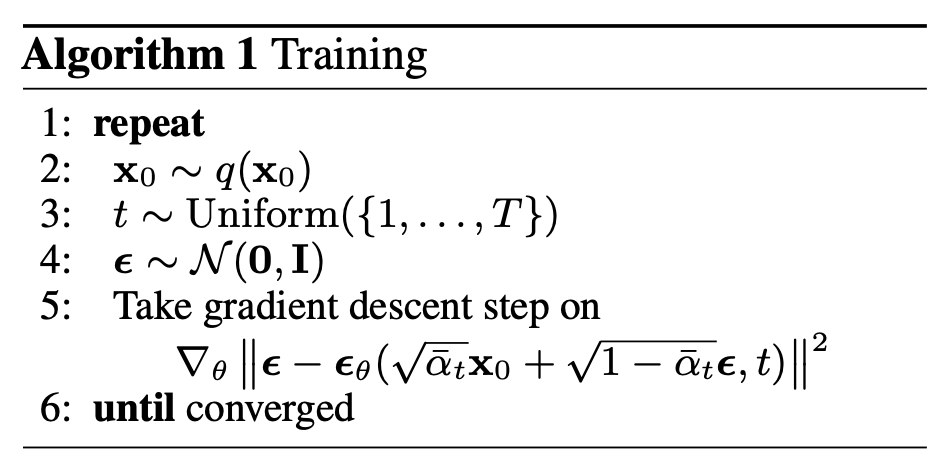


`DiffusionTrainer`
- `calc_loss(clean_images: FloatTensor)` - необходимо внутри метода просемплировать время, далее просемплировать $x_t$, обработать батч, рассчитать лосс для обучения

In [56]:
from torch_ema import ExponentialMovingAverage
import wandb
import math
import torchvision


class DiffusionTrainer:
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic,
        device: torch.device = torch.device('cpu')
    ):
        self.ddpm = ddpm
        self.dynamic = dynamic

        self.dynamic.to(device)
        self.ddpm.to(device)

        self.sampler = Sampler(ddpm, dynamic)
        self.sampler.to(device)

        self.ema = ExponentialMovingAverage(ddpm.parameters(), decay=0.999)

        self.device = device


        self.optimizer = torch.optim.AdamW(
            self.ddpm.parameters(),
            lr=2e-4,
            weight_decay=1e-2
        )

        self.step = 0

    def switch_to_ema(self) -> None:
        self.ema.store(self.ddpm.parameters())
        self.ema.copy_to(self.ddpm.parameters())

    def switch_back_from_ema(self) -> None:
        self.ema.restore(self.ddpm.parameters())

    def calc_loss(self, x_0: torch.Tensor) -> torch.Tensor:
        batch_size = x_0.shape[0]
        t = self.dynamic.sample_time_on_device(batch_size, self.device)
        dynamic_res = self.dynamic({
            'x_0': x_0,
            't': t
        })
        x_t = dynamic_res['x_t']
        eps = dynamic_res['eps']
        eps_pred = self.ddpm(x_t, t)
        return torch.sum((eps - eps_pred) ** 2)

    def log_metric(self, metric_name: str, loader_name: str, value: Union[float, torch.Tensor, wandb.Image]):
        wandb.log({f'{metric_name}/{loader_name}': value}, step=self.step)

    def optimizer_logic(self, loss: torch.Tensor) -> None:
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.ema.update(self.ddpm.parameters())

    def train(
            self,
            train_generator: Generator[Dict[str, Tensor], None, None],
            total_iters: int = 1000,
            project_name: str = 'discrete_time_ddpm',
            experiment_name: str = 'mnist_baseline'
        ) -> None:
        session = wandb.init(project=project_name, name=experiment_name)

        self.ddpm.train()

        for iter_idx in trange(1, 1 + total_iters):
            self.step = iter_idx

            batch = next(train_generator)
            batch = dict_to_device(batch, device=self.device)

            loss = self.calc_loss(x_0=batch['images'])
            self.log_metric('mse', 'train', loss)

            self.optimizer_logic(loss)

            if iter_idx % 1000 == 0:
                self.snapshot()

        self.ddpm.eval()
        self.switch_to_ema()

        session.finish()

    @torch.no_grad()
    def sample_images(
            self, batch_size: int,
            verbose: bool = False
    ) -> torch.Tensor:
        x_pred = self.sampler.sample((batch_size, 1, 32, 32), self.device, verbose)
        x_pred = postprocess_image(x_pred)
        return x_pred

    @torch.no_grad()
    def snapshot(self) -> None:
        prev_mode = self.ddpm.training

        self.ddpm.eval()
        self.switch_to_ema()

        images = self.sample_images(100).cpu()
        nrow = 10
        grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
        grid = grid.data.numpy().astype(np.uint8)
        self.log_metric('images', 'from_noise', wandb.Image(grid))

        self.switch_back_from_ema()
        self.ddpm.train(prev_mode)

In [57]:
from denoising_diffusion_pytorch import Unet

ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 4),
    channels=1,
    flash_attn=True
)

In [58]:
device = torch.device('cuda:0')

In [59]:
trainer = DiffusionTrainer(
    ddpm,
    DDPMDynamic(),
    device
)

In [60]:
generator = get_train_images_generator(128)

In [61]:
trainer.train(
    generator,
    total_iters=5000
)

wandb: Currently logged in as: danilkes (makriot). Use `wandb login --relogin` to force relogin


  0%|          | 0/5000 [00:00<?, ?it/s]

mse/train,█▄▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▂▁▂▁▁▁▂▂▁▁▂▁
mse/train,1864.76953


#### Безусловная генерация (неплохих картинок - 1 pts)

  0%|          | 0/1000 [00:00<?, ?it/s]

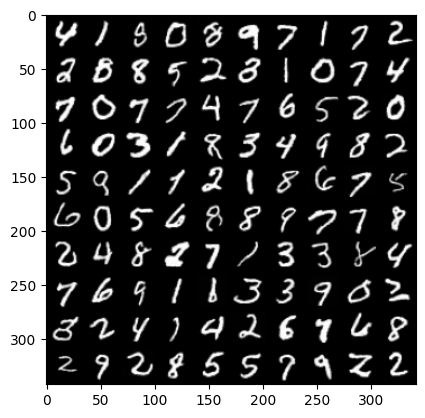

In [62]:
from matplotlib import pyplot as plt
import math


def sample_images(
    sampler: Sampler, batch_size: int == 100,
    device = torch.device('cpu'),
    verbose: bool = True
):
    images = sampler.sample((batch_size, 1, 32, 32), device, verbose)
    images = postprocess_image(images)
    images = images.cpu()
    nrow = int(math.ceil(math.sqrt(batch_size)))
    grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)
    return grid

grid = sample_images(trainer.sampler, 100, trainer.device)

plt.imshow(grid)

### Выводы/результаты:
---

Получилось реализовать логику диффузионки из статьи, обучить её, и запустить. Сгенерированные картинки выглядят прям как настоящие! (кайф). Открыл для себя суперполезный способ отслеживать обучение нейронок: "wandb", буду использовать для следующих экспериментов.

Из особенностей экспериментов можно отметить что диффузионка действительно не быстро генерирует, и вопрос ускорения генерации остаётся актуальным. Также стоит отметить, что мы добились хорошего качества используя "простой" loss, т.е. без использования теоретических коэффициентов, и в будущем хотелось бы попробовать сравнить результаты с теоретической лосс функцией. Дальше хотелось бы применить эту модель к CIFAR.